# Toronto Housing Pricing Analysis Dashboard


In [1]:
# imports
import numpy as np
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import os
import seaborn as sns
from pathlib import Path
from dotenv import load_dotenv

import datetime
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import pyplot as plt
%matplotlib inline
from pandas.plotting import scatter_matrix

from sklearn.cluster import KMeans
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    KFold,
    GridSearchCV)
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn import neighbors

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# create a Graphviz file
from sklearn.tree import export_graphviz
from IPython.display import Image

# import StringIO, pydot
# import pylab, pydotplus
from six import StringIO

# import xgboost
import xgboost as xgb
import os 
# import keras functions

import keras
from keras import Sequential, regularizers
from keras.optimizers import SGD, RMSprop, Adam
from keras.layers import Dense, Dropout, Activation
from keras.wrappers.scikit_learn import KerasRegressor
from keras.utils import np_utils

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium  # map rendering library

import time

print("Libraries imported.")

Using TensorFlow backend.
C:\Users\Office\.conda\envs\dev\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Office\.conda\envs\dev\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Office\.conda\envs\dev\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Office\.conda\envs\dev\lib\site-packages\tensorflo

Libraries imported.


C:\Users\Office\AppData\Roaming\Python\Python37\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Office\AppData\Roaming\Python\Python37\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Office\AppData\Roaming\Python\Python37\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Office\AppData\Roam

# Importing data

In [2]:
canada_data = Path('Data\Canada.xlsx')
cpi_ontario_data = Path('Data\cpi_ontario.csv')
gta_data = Path('Data\GTA.csv')
income_age_data = Path('Data\household_income_by_age_2000_2018.csv')
income_family_data = Path('Data\household_income_by_family_type_2000_2018.csv')
hpi_house_data = Path('Data\hpi_by_housing_type_2005_2021.csv')
primary_rate_data = Path('Data\primary_rate_canada.csv')
neigh_census_data = Path('Data/toronto_neighbourhoods_census_data.csv')
neigh_coordinates_data = Path('Data/toronto_neighbourhoods_coordinates.csv')
neigh_hist_data = Path('Data/toronto_neighbourhoods_historical_data.csv')
neigh_hist_people_data = Path('Data/toronto_neighbourhoods_historical_people_data.csv')
macro_pct_path = Path('Data/yearly_macro_variables_changing_pct_summary.csv')
macro_var_summary_data = Path('Data/yearly_macro_variables_summary.csv')

In [3]:
canada = pd.read_excel(canada_data,  parse_dates = True)
cpi_ontario = pd.read_csv(cpi_ontario_data, parse_dates = True)
gta = pd.read_csv(gta_data, parse_dates = True)
income_age = pd.read_csv(income_age_data, parse_dates = True)
income_family = pd.read_csv(income_family_data, parse_dates = True)
hpi_house = pd.read_csv(hpi_house_data, parse_dates = True)
primary_rate = pd.read_csv(primary_rate_data, parse_dates = True)
neigh_census = pd.read_csv(neigh_census_data, parse_dates = True)
neigh_coordinates = pd.read_csv(neigh_coordinates_data, parse_dates = True)
neigh_hist = pd.read_csv(neigh_hist_data, parse_dates = True)
neigh_hist_people = pd.read_csv(neigh_hist_people_data, parse_dates = True)
yearly_macro_pct_data = pd.read_csv(macro_pct_path, parse_dates = True)
macro_var_summary = pd.read_csv(macro_var_summary_data, parse_dates = True)

## Cleaning up all data for analysis

In [4]:
neigh_hist.head()
neigh_hist_d1 = neigh_hist.melt(id_vars = 'neighbourhood')
neigh_hist_d1.rename(columns = {'variable' : 'year'}, inplace = True)
neigh_hist_d1 = neigh_hist_d1[['year', 'neighbourhood', 'value']].drop_duplicates()
neigh_hist_d1.head()

year                 neighbourhood   value
0  2001               Agincourt North  200388
1  2001  Agincourt South-Malvern West  203047
2  2001                     Alderwood  259998
3  2001                         Annex  453850
4  2001             Banbury-Don Mills  371864

In [5]:
# Calculating Average house prices based on different categories of houses
gta['year'] = pd.DatetimeIndex(gta['Date']).year
gta = gta[['year', 'Composite_Benchmark_SA', 'Single_Family_Benchmark_SA', 'One_Storey_Benchmark_SA', 'Two_Storey_Benchmark_SA', 'Townhouse_Benchmark_SA', 'Apartment_Benchmark_SA']]
gta_avg = gta.groupby('year').mean()
gta_avg.reset_index(inplace = True)
gta_avg.head()

year  Composite_Benchmark_SA  Single_Family_Benchmark_SA  \
0  2005           316133.333333               360750.000000   
1  2006           331933.333333               379333.333333   
2  2007           350925.000000               401175.000000   
3  2008           363975.000000               412450.000000   
4  2009           365091.666667               412016.666667   

   One_Storey_Benchmark_SA  Two_Storey_Benchmark_SA  Townhouse_Benchmark_SA  \
0            317725.000000            375683.333333           220675.000000   
1            334600.000000            394941.666667           230808.333333   
2            353375.000000            417808.333333           242425.000000   
3            361291.666667            430341.666667           251141.666667   
4            357625.000000            431108.333333           250550.000000   

   Apartment_Benchmark_SA  
0                203275.0  
1                212800.0  
2                225575.0  
3                240875.0  
4                244825.0

In [6]:
# Macro variables
df_macro_pct= pd.read_csv(macro_pct_path, index_col="Year")
df_macro_pct

# Affordable neighborhood

# Most expensive neighborhoods

# Neighorhodd growth

# Housing price prediction


Consumer Price Index (CPI)  Household Income  Prime Rate  \
Year                                                             
2006                    0.017683          0.032362    0.314480   
2007                    0.018295          0.043260    0.049914   
2008                    0.022752          0.023438   -0.224590   
2009                    0.003708         -0.019524   -0.492600   
2010                    0.024362          0.019763    0.083333   
2011                    0.030823          0.023932    0.153846   
2012                    0.014076          0.021078    0.000000   
2013                    0.010513          0.022750    0.000000   
2014                    0.023165          0.033503    0.000000   
2015                    0.012154          0.039989   -0.073333   
2016                    0.017816          0.025933   -0.028777   
2017                    0.016888          0.033744    0.077778   
2018                    0.023508          0.043965    0.250859   

      Unemployment Rate  House Price Index (HPI)  Benchmark Housing Value  
Year                                                                       
2006          -0.049107                 0.050044                 0.049979  
2007           0.015649                 0.057153                 0.057215  
2008           0.027735                 0.037158                 0.037187  
2009           0.389805                 0.003056                 0.003068  
2010          -0.046386                 0.101481                 0.101481  
2011          -0.095023                 0.064546                 0.064467  
2012           0.005000                 0.068356                 0.068486  
2013          -0.038557                 0.042767                 0.042634  
2014          -0.036223                 0.074381                 0.074477  
2015          -0.076510                 0.093354                 0.093368  
2016          -0.020349                 0.163376                 0.163337  
2017          -0.086053                 0.185473                 0.185449  
2018          -0.055195                -0.001720                -0.001704

## Expensive Neighbours

In [7]:
# Load .env
load_dotenv()
mapbox_api_key = os.getenv("MAPBOX_API_KEY")
px.set_mapbox_access_token(mapbox_api_key)

# Reading GTA Neighbourhood data
gta_data = Path("Data/toronto_neighbourhoods_census_data.csv")
gta_df= pd.read_csv(gta_data, index_col="year").dropna()
gta_expensive_neighbourhoods = gta_df.groupby('neighbourhood').mean().sort_values(ascending=False, by="average_house_value")
gta_expensive_neighbourhoods = gta_expensive_neighbourhoods.reset_index()

# Plotting GTA Neighbourhoods by Price
gta_expensive_neighbourhoods_plot = gta_expensive_neighbourhoods.hvplot.bar(x="neighbourhood", y="average_house_value", xlabel='Neighbourhood', ylabel='Avg. House Value', title="GTA Neighbourhoods by Price", height=700, width= 1900, rot=90, yformatter='%.0f')

In [8]:
# Importing geopy
from geopy import Nominatim 
#import geopandas
from geopy.extra.rate_limiter import RateLimiter

# You can disable api since it takes a lot of time to receive coordinations, and use offline data instead.
use_api = False

if use_api == True:
    # Initializing Nominatim locator
    locator = Nominatim(user_agent="myGeocoder")

    geo_df = gta_df['neighbourhood'].reset_index().drop(columns=['year'])
    geo_df['address'] = geo_df + ", ON, Canada"

    # geo_df = geo_df.head(3) 

    # conveneint function to delay between geocoding calls
    geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
    geo_df['location'] = geo_df['address'].apply(geocode)
    geo_df['point'] = geo_df['location'].apply(lambda loc: tuple(loc.point) if loc else None).tolist()
    geo_df[['lat', 'lon', 'alt']] = pd.DataFrame(geo_df['point'].tolist(), index=geo_df.index)

    geo_df = geo_df[['neighbourhood', 'lat', 'lon']]
else:
    geo_df = pd.read_csv(neigh_coordinates_data).dropna()

geo_df.head()

neighbourhood        lat        lon
0               Agincourt North  43.805441 -79.266712
1  Agincourt South-Malvern West  43.788658 -79.265612
2                     Alderwood  43.604937 -79.541611
3                         Annex  43.671585 -79.404001
4             Banbury-Don Mills  43.737657 -79.349718

In [9]:
# Join the average values with the neighbourhood locations
neighbourhood_locations = pd.concat([geo_df, gta_expensive_neighbourhoods.drop(columns=['neighbourhood'])], axis="columns", join="inner")
neighbourhood_locations.head()

neighbourhood        lat        lon  single_detached_house  \
0               Agincourt North  43.805441 -79.266712                2260.00   
1  Agincourt South-Malvern West  43.788658 -79.265612                1742.50   
2                     Alderwood  43.604937 -79.541611                3472.50   
3                         Annex  43.671585 -79.404001                2498.75   
4             Banbury-Don Mills  43.737657 -79.349718                3225.00   

   apartment_five_storeys_plus  movable_dwelling  semi_detached_house  \
0                       331.25              0.00                36.25   
1                      2031.25              1.25                61.25   
2                       773.75              0.00               126.25   
3                      4641.25              0.00               486.25   
4                      1670.00              0.00               185.00   

   row_house  duplex  apartment_five_storeys_less  other_house  \
0      90.00    25.0                        40.00         0.00   
1      45.00    75.0                      1027.50         3.75   
2      38.75   225.0                       966.25        16.25   
3     245.00   327.5                      1618.75         2.50   
4     552.50    97.5                       586.25         5.00   

   average_house_value  shelter_costs_owned  shelter_costs_rented  
0           1526485.75              2360.75               2321.75  
1           1195992.50              1781.00               1313.75  
2           1094027.75              1954.00               1372.75  
3           1093640.00              1909.75               1537.25  
4            999107.00              1880.25               1384.50

## Affordable Neighborhoods

In [10]:
# Import the CSVs to Pandas DataFrames
GTA_data = pd.read_csv(neigh_census_data, index_col="neighbourhood")
# Getting the data from the top 10 cheaper neighbourhoods
cheaper_neighbourhoods = GTA_data.groupby(by="neighbourhood").mean()
cheaper_neighbourhoods.reset_index(inplace=True)
cheaper_neighbourhoods.sort_values(by="average_house_value", ascending=True , inplace=True)
cheaper_neighbourhoods.head(10)

neighbourhood    year  single_detached_house  \
42                     Flemingdon Park  2008.5                   5.00   
115                      Taylor-Massey  2008.5                 622.50   
81   Mount Olive-Silverstone-Jamestown  2008.5                1730.00   
118                   Thorncliffe Park  2008.5                   3.75   
73                             Malvern  2008.5                3693.75   
13                         Black Creek  2008.5                 732.50   
31                         Dorset Park  2008.5                2106.25   
80                        Mount Dennis  2008.5                1028.75   
38                    Elms-Old Rexdale  2008.5                1036.25   
37                       Eglinton East  2008.5                1637.50   

     apartment_five_storeys_plus  movable_dwelling  semi_detached_house  \
42                       6368.75              0.00               182.50   
115                      4795.00              0.00               203.75   
81                       5916.25              1.25               176.25   
118                      6318.75              0.00                 0.00   
73                       2982.50              0.00              1317.50   
13                       4356.25              0.00               685.00   
31                       3743.75              0.00               326.25   
80                       2238.75              0.00               138.75   
38                       1377.50              0.00                75.00   
37                       5045.00              0.00               108.75   

     row_house  duplex  apartment_five_storeys_less  other_house  \
42      630.00    3.75                       591.25         0.00   
115     216.25  150.00                       218.75        15.00   
81     1033.75  603.75                       127.50         1.25   
118     141.25    0.00                       187.50         5.00   
73     3410.00  878.75                       552.50        55.00   
13     1116.25  113.75                       238.75         2.50   
31     1318.75  405.00                       413.75         3.75   
80      302.50  176.25                       912.50         2.50   
38      476.25  153.75                        50.00         0.00   
37      403.75  481.25                       251.25         6.25   

     average_house_value  shelter_costs_owned  shelter_costs_rented  
42             207799.00              1199.75                973.00  
115            239414.00              1129.25                919.25  
81             253182.25              1159.50                955.25  
118            255264.75              1304.25               1088.50  
73             256880.25              1228.00                998.75  
13             260841.75              1011.75                864.50  
31             262000.25              1152.25                953.50  
80             262308.75              1244.75                957.25  
38             268341.25              1202.25                998.50  
37             268966.50              1103.50                907.25

In [11]:
# Import the CSVs to Pandas DataFrames
GTA_data = pd.read_csv(neigh_census_data, index_col="neighbourhood")
# Getting the data from the top 10 cheaper neighbourhoods
cheaper_neighbourhoods = GTA_data.groupby(by="neighbourhood").mean()
cheaper_neighbourhoods.reset_index(inplace=True)
cheaper_neighbourhoods.sort_values(by="average_house_value", ascending=True , inplace=True)
cheaper_neighbourhoods.head(10)

neighbourhood    year  single_detached_house  \
42                     Flemingdon Park  2008.5                   5.00   
115                      Taylor-Massey  2008.5                 622.50   
81   Mount Olive-Silverstone-Jamestown  2008.5                1730.00   
118                   Thorncliffe Park  2008.5                   3.75   
73                             Malvern  2008.5                3693.75   
13                         Black Creek  2008.5                 732.50   
31                         Dorset Park  2008.5                2106.25   
80                        Mount Dennis  2008.5                1028.75   
38                    Elms-Old Rexdale  2008.5                1036.25   
37                       Eglinton East  2008.5                1637.50   

     apartment_five_storeys_plus  movable_dwelling  semi_detached_house  \
42                       6368.75              0.00               182.50   
115                      4795.00              0.00               203.75   
81                       5916.25              1.25               176.25   
118                      6318.75              0.00                 0.00   
73                       2982.50              0.00              1317.50   
13                       4356.25              0.00               685.00   
31                       3743.75              0.00               326.25   
80                       2238.75              0.00               138.75   
38                       1377.50              0.00                75.00   
37                       5045.00              0.00               108.75   

     row_house  duplex  apartment_five_storeys_less  other_house  \
42      630.00    3.75                       591.25         0.00   
115     216.25  150.00                       218.75        15.00   
81     1033.75  603.75                       127.50         1.25   
118     141.25    0.00                       187.50         5.00   
73     3410.00  878.75                       552.50        55.00   
13     1116.25  113.75                       238.75         2.50   
31     1318.75  405.00                       413.75         3.75   
80      302.50  176.25                       912.50         2.50   
38      476.25  153.75                        50.00         0.00   
37      403.75  481.25                       251.25         6.25   

     average_house_value  shelter_costs_owned  shelter_costs_rented  
42             207799.00              1199.75                973.00  
115            239414.00              1129.25                919.25  
81             253182.25              1159.50                955.25  
118            255264.75              1304.25               1088.50  
73             256880.25              1228.00                998.75  
13             260841.75              1011.75                864.50  
31             262000.25              1152.25                953.50  
80             262308.75              1244.75                957.25  
38             268341.25              1202.25                998.50  
37             268966.50              1103.50                907.25

In [12]:
# Plotting the d 10 cheapest neighbourhoods
# YOUR CODE HERE!
cheaper_neighbourhoods.sort_values('average_house_value' , ascending=True , inplace=True)
cheapest = cheaper_neighbourhoods.head(10)
cheapest_plot = cheapest.hvplot.bar(y='average_house_value' ,  x='neighbourhood' , width=1250 , height=500 , ylabel= 'average house value' , xlabel= 'neighbourhoods'  , yformatter='%.0f' , rot=90)

In [13]:
# Calculate the average monthly shelter costs for owned dwellings, show 10 more affordable 
avg_monthly_costs_owned= GTA_data[['shelter_costs_owned']].groupby(["neighbourhood"]).mean()
avg_monthly_costs_owned.reset_index(inplace=True)
avg_monthly_costs_owned.sort_values(by='shelter_costs_owned', ascending=True, inplace=True)
#average_monthly_costs.sort_values(by='shelter_costs_rented', ascending=True, inplace=True)
avg_monthly_costs_owned.head(10)

neighbourhood  shelter_costs_owned
13               Black Creek              1011.75
10   Beechborough-Greenbrook              1029.25
107                   Rustic              1032.75
90         O'Connor-Parkview              1038.25
123                West Hill              1071.50
45    Glenfield-Jane Heights              1080.00
61              Kennedy Park              1083.75
74                Maple Leaf              1089.00
128         Wexford/Maryvale              1092.50
33      Downsview-Roding-CFB              1096.00

In [14]:
# Calculate the average monthly shelter costs for rented dwellings, show 10 more affordable 
avg_monthly_costs_rented= GTA_data[['shelter_costs_rented']].groupby(["neighbourhood"]).mean()
avg_monthly_costs_rented.reset_index(inplace=True)
avg_monthly_costs_rented.sort_values(by='shelter_costs_rented', ascending=True, inplace=True)
#average_monthly_costs.sort_values(by='shelter_costs_rented', ascending=True, inplace=True)
avg_monthly_costs_rented.head(10)

neighbourhood  shelter_costs_rented
123                 West Hill                761.25
52          Hillcrest Village                765.75
90          O'Connor-Parkview                785.50
107                    Rustic                791.75
10    Beechborough-Greenbrook                797.50
127        Weston-Pellam Park                804.50
61               Kennedy Park                805.25
100               Regent Park                815.25
60   Keelesdale-Eglinton West                855.25
45     Glenfield-Jane Heights                860.50

## Neighbourhood Growth

In [15]:
# Reading GTA Neighbourhood data
people_df= pd.read_csv(neigh_hist_people_data, index_col="neighbourhood").dropna()
people_df.head()

2001  2002  2003  2004  2005  2006  2007  2008  \
neighbourhood                                                                  
Agincourt North                  3     1     1     1     6     2     6     7   
Agincourt South-Malvern West     1     2     4     3     5     3     6     8   
Alderwood                        1     2     1     1     1     1     3     1   
Annex                            1     6    10    10    10    10    10     6   
Banbury-Don Mills                4     7     4     8     8     7     8    10   

                              2009  2010  ...  2012  2013  2014  2015  2016  \
neighbourhood                             ...                                 
Agincourt North                  7     5  ...     2     6     6     2     1   
Agincourt South-Malvern West    10     7  ...     9     7    10    10    10   
Alderwood                        2     6  ...     6     6     6     7    10   
Annex                            2     7  ...     5     3     3     1     1   
Banbury-Don Mills                6    10  ...     8     7    10    10     9   

                              2017  2018  2019  2020  2021  
neighbourhood                                               
Agincourt North                  2     3     4     4     4  
Agincourt South-Malvern West    10     7    10    10     7  
Alderwood                        6     6     3     1     1  
Annex                            5     8     8    10    10  
Banbury-Don Mills               10     7     4     7     8  

[5 rows x 21 columns]

In [16]:
# Calculating growth rates
growth = people_df.pct_change(axis=1).dropna(axis=1)

# Calculating the average growth
average_growth = growth.mean(axis=1)

# Sort by the most growth rate
average_growth = average_growth.sort_values(ascending=False)

average_growth = average_growth.reset_index()
average_growth.columns = ['neighbourhood', 'Average Growth Rate']
average_growth.head()

neighbourhood  Average Growth Rate
0                      Pleasant View             0.777321
1                   Victoria Village             0.674881
2            Beechborough-Greenbrook             0.653889
3                 Caledonia-Fairbank             0.605000
4  Dovercourt-Wallace Emerson-Juncti             0.573155

In [17]:
# Plotting the growth
average_growth_plot = average_growth.hvplot.bar(x="neighbourhood", xlabel='Neighbourhood', ylabel='Avg. Growth Rate', title="GTA Neighbourhoods by the most growth rate", height=700, width= 1900, rot=90, yformatter='%.0f')
# Combining datasets
neighbourhood_growth_locations = pd.concat([geo_df, average_growth.drop(columns=['neighbourhood'])], axis="columns", join="inner")
neighbourhood_growth_locations.head()

neighbourhood        lat        lon  Average Growth Rate
0               Agincourt North  43.805441 -79.266712             0.777321
1  Agincourt South-Malvern West  43.788658 -79.265612             0.674881
2                     Alderwood  43.604937 -79.541611             0.653889
3                         Annex  43.671585 -79.404001             0.605000
4             Banbury-Don Mills  43.737657 -79.349718             0.573155

## Consolidating all variables into one Dataset at a yearly basis

In [18]:
var_consolidation = pd.merge(left = gta_avg, right = macro_var_summary, how = 'inner', left_on = 'year', right_on = 'Year')
var_consolidation.drop(columns = 'Year', inplace = True)
var_consolidation.head()

year  Composite_Benchmark_SA  Single_Family_Benchmark_SA  \
0  2005           316133.333333               360750.000000   
1  2006           331933.333333               379333.333333   
2  2007           350925.000000               401175.000000   
3  2008           363975.000000               412450.000000   
4  2009           365091.666667               412016.666667   

   One_Storey_Benchmark_SA  Two_Storey_Benchmark_SA  Townhouse_Benchmark_SA  \
0            317725.000000            375683.333333           220675.000000   
1            334600.000000            394941.666667           230808.333333   
2            353375.000000            417808.333333           242425.000000   
3            361291.666667            430341.666667           251141.666667   
4            357625.000000            431108.333333           250550.000000   

   Apartment_Benchmark_SA  Consumer Price Index (CPI)  Household Income  \
0                203275.0                      106.88           61800.0   
1                212800.0                      108.77           63800.0   
2                225575.0                      110.76           66560.0   
3                240875.0                      113.28           68120.0   
4                244825.0                      113.70           66790.0   

   Prime Rate  Unemployment Rate  House Price Index (HPI)  \
0        4.42               6.72                   102.31   
1        5.81               6.39                   107.43   
2        6.10               6.49                   113.57   
3        4.73               6.67                   117.79   
4        2.40               9.27                   118.15   

   Benchmark Housing Value  
0                316133.33  
1                331933.33  
2                350925.00  
3                363975.00  
4                365091.67

In [19]:
# Setting up dataframe based on year to merge with another dataset
primary_rate['year'] = pd.DatetimeIndex(primary_rate['Date']).year
primary_rate = primary_rate[['year', 'Prime Rate', 'Bank of Canada Overnight Rate']]
primary_rate_df = primary_rate.groupby('year').mean()
primary_rate_df.head()

Prime Rate  Bank of Canada Overnight Rate
year                                           
2000    7.270833                       4.833333
2001    5.812500                       4.062500
2002    4.208333                       2.458333
2003    4.687500                       2.937500
2004    4.000000                       2.250000

## Grouping All Datasets into one

In [20]:
# Merge the coordinates based on the neighbourhood
neighbourhood_census_coordinates = pd.merge(left = neigh_census, right = neigh_coordinates, how = 'inner', left_on = 'neighbourhood', right_on = 'neighbourhood')
# merge the bank rate with the above dataset
neigh_data_bank_rate = pd.merge(left = neighbourhood_census_coordinates, right = primary_rate_df, how = 'inner', left_on = 'year', right_on = 'year')
# bringing in historical Prices based on neighbourhood
neigh_data_bank_rate['year'] = neigh_data_bank_rate.year.astype(object)
# bringing variables into the overall dataset
df_consolidation = pd.merge(left = neigh_data_bank_rate, right = var_consolidation, how = 'inner', left_on = 'year', right_on = 'year')
list_of_columns = df_consolidation.columns
df_consolidation.head()

year                 neighbourhood  single_detached_house  \
0  2006               Agincourt North                   3295   
1  2006  Agincourt South-Malvern West                   2695   
2  2006                     Alderwood                   2750   
3  2006                         Annex                    630   
4  2006             Banbury-Don Mills                   3620   

   apartment_five_storeys_plus  movable_dwelling  semi_detached_house  \
0                         2060                 0                  775   
1                         1840                 5                  305   
2                          315                 5                  480   
3                         7135                 0                 1120   
4                         5020                 5                  285   

   row_house  duplex  apartment_five_storeys_less  other_house  ...  \
0       1425     600                          565            0  ...   
1        420     610                          860            5  ...   
2         85     370                          540            5  ...   
3        620     240                         4955           15  ...   
4        660      30                         1330            0  ...   

   One_Storey_Benchmark_SA  Two_Storey_Benchmark_SA  Townhouse_Benchmark_SA  \
0                 334600.0            394941.666667           230808.333333   
1                 334600.0            394941.666667           230808.333333   
2                 334600.0            394941.666667           230808.333333   
3                 334600.0            394941.666667           230808.333333   
4                 334600.0            394941.666667           230808.333333   

   Apartment_Benchmark_SA  Consumer Price Index (CPI)  Household Income  \
0                212800.0                      108.77           63800.0   
1                212800.0                      108.77           63800.0   
2                212800.0                      108.77           63800.0   
3                212800.0                      108.77           63800.0   
4                212800.0                      108.77           63800.0   

   Prime Rate_y  Unemployment Rate  House Price Index (HPI)  \
0          5.81               6.39                   107.43   
1          5.81               6.39                   107.43   
2          5.81               6.39                   107.43   
3          5.81               6.39                   107.43   
4          5.81               6.39                   107.43   

   Benchmark Housing Value  
0                331933.33  
1                331933.33  
2                331933.33  
3                331933.33  
4                331933.33  

[5 rows x 29 columns]

## Limiting the dataset to the most recent year

In [21]:
df_consolidation.groupby(['year', 'neighbourhood']).mean()
df_consolidation.sort_values(['year','average_house_value'], ascending = [True, False], inplace = True)
df_consolidation.tail()

year                      neighbourhood  single_detached_house  \
353  2016                            Malvern                   3475   
398  2016                   Thorncliffe Park                      0   
361  2016  Mount Olive-Silverstone-Jamestown                   1655   
395  2016                      Taylor-Massey                    600   
322  2016                    Flemingdon Park                      0   

     apartment_five_storeys_plus  movable_dwelling  semi_detached_house  \
353                         3175                 0                 1275   
398                         6660                 0                    0   
361                         6165                 0                  160   
395                         4840                 0                  195   
322                         6425                 0                  180   

     row_house  duplex  apartment_five_storeys_less  other_house  ...  \
353       3540    1220                          655           85  ...   
398         85       0                          375            0  ...   
361       1040     755                           90            0  ...   
395        185     195                          240           25  ...   
322        565       5                          645            0  ...   

     One_Storey_Benchmark_SA  Two_Storey_Benchmark_SA  Townhouse_Benchmark_SA  \
353            684833.333333                 819775.0                435000.0   
398            684833.333333                 819775.0                435000.0   
361            684833.333333                 819775.0                435000.0   
395            684833.333333                 819775.0                435000.0   
322            684833.333333                 819775.0                435000.0   

     Apartment_Benchmark_SA  Consumer Price Index (CPI)  Household Income  \
353                359575.0                      129.68           80310.0   
398                359575.0                      129.68           80310.0   
361                359575.0                      129.68           80310.0   
395                359575.0                      129.68           80310.0   
322                359575.0                      129.68           80310.0   

     Prime Rate_y  Unemployment Rate  House Price Index (HPI)  \
353           2.7               6.74                   210.92   
398           2.7               6.74                   210.92   
361           2.7               6.74                   210.92   
395           2.7               6.74                   210.92   
322           2.7               6.74                   210.92   

     Benchmark Housing Value  
353                 651750.0  
398                 651750.0  
361                 651750.0  
395                 651750.0  
322                 651750.0  

[5 rows x 29 columns]

In [22]:
year_list = []
for x in df_consolidation['year'].sort_values():
    if x not in year_list:
        year_list.append(x)

recent_year = year_list[-1]

In [23]:
latest_df = df_consolidation[df_consolidation['year'] == recent_year]
latest_df

year                      neighbourhood  single_detached_house  \
296  2016  Bridle Path-Sunnybrook-York Mills                   2275   
324  2016                  Forest Hill South                   1685   
349  2016                Lawrence Park South                   3420   
384  2016                Rosedale-Moore Park                   2450   
391  2016               St.Andrew-Windfields                   3245   
..    ...                                ...                    ...   
353  2016                            Malvern                   3475   
398  2016                   Thorncliffe Park                      0   
361  2016  Mount Olive-Silverstone-Jamestown                   1655   
395  2016                      Taylor-Massey                    600   
322  2016                    Flemingdon Park                      0   

     apartment_five_storeys_plus  movable_dwelling  semi_detached_house  \
296                          590                 0                   40   
324                         2025                 0                   65   
349                          925                 0                  110   
384                         4990                 0                  485   
391                         1745                 0                  175   
..                           ...               ...                  ...   
353                         3175                 0                 1275   
398                         6660                 0                    0   
361                         6165                 0                  160   
395                         4840                 0                  195   
322                         6425                 0                  180   

     row_house  duplex  apartment_five_storeys_less  other_house  ...  \
296        230      30                           80            0  ...   
324         40      70                         1050            0  ...   
349         35     230                         1015            5  ...   
384        260     345                         1505            5  ...   
391        540     120                          595            5  ...   
..         ...     ...                          ...          ...  ...   
353       3540    1220                          655           85  ...   
398         85       0                          375            0  ...   
361       1040     755                           90            0  ...   
395        185     195                          240           25  ...   
322        565       5                          645            0  ...   

     One_Storey_Benchmark_SA  Two_Storey_Benchmark_SA  Townhouse_Benchmark_SA  \
296            684833.333333                 819775.0                435000.0   
324            684833.333333                 819775.0                435000.0   
349            684833.333333                 819775.0                435000.0   
384            684833.333333                 819775.0                435000.0   
391            684833.333333                 819775.0                435000.0   
..                       ...                      ...                     ...   
353            684833.333333                 819775.0                435000.0   
398            684833.333333                 819775.0                435000.0   
361            684833.333333                 819775.0                435000.0   
395            684833.333333                 819775.0                435000.0   
322            684833.333333                 819775.0                435000.0   

     Apartment_Benchmark_SA  Consumer Price Index (CPI)  Household Income  \
296                359575.0                      129.68           80310.0   
324                359575.0                      129.68           80310.0   
349                359575.0                      129.68           80310.0   
384                359575.0                      129.68           80310.0   
391             

## Creating Cooefficient Matrix

In [24]:
dataset_cols = list(latest_df)
cols = []
for x in dataset_cols:
    if x not in ['year', 'neighbourhood', 'lat', 'lon']:
        cols.append(x)
        
        
list(cols)
coef = np.corrcoef(latest_df[cols].values.T)
coef_matrix = pd.DataFrame(coef, columns = cols, index = cols)
coef_matrix.head()

C:\Users\Office\.conda\envs\dev\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Office\.conda\envs\dev\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


single_detached_house  \
single_detached_house                     1.000000   
apartment_five_storeys_plus              -0.153199   
movable_dwelling                          0.064259   
semi_detached_house                      -0.081730   
row_house                                 0.209109   

                             apartment_five_storeys_plus  movable_dwelling  \
single_detached_house                          -0.153199          0.064259   
apartment_five_storeys_plus                     1.000000         -0.082457   
movable_dwelling                               -0.082457          1.000000   
semi_detached_house                            -0.208599          0.142440   
row_house                                       0.147607          0.027792   

                             semi_detached_house  row_house    duplex  \
single_detached_house                  -0.081730   0.209109  0.495530   
apartment_five_storeys_plus            -0.208599   0.147607 -0.114219   
movable_dwelling                        0.142440   0.027792  0.146691   
semi_detached_house                     1.000000   0.309624  0.184273   
row_house                               0.309624   1.000000  0.368666   

                             apartment_five_storeys_less  other_house  \
single_detached_house                          -0.162663    -0.115848   
apartment_five_storeys_plus                    -0.013098    -0.046362   
movable_dwelling                                0.220564     0.019601   
semi_detached_house                             0.421881     0.241908   
row_house                                       0.083693     0.212898   

                             average_house_value  shelter_costs_owned  ...  \
single_detached_house                   0.076087            -0.100503  ...   
apartment_five_storeys_plus            -0.149417             0.124604  ...   
movable_dwelling                       -0.082996            -0.076312  ...   
semi_detached_house                    -0.074948            -0.066279  ...   
row_house                              -0.286759            -0.217666  ...   

                             One_Storey_Benchmark_SA  Two_Storey_Benchmark_SA  \
single_detached_house                  -1.335543e-16                      NaN   
apartment_five_storeys_plus             3.445062e-17                      NaN   
movable_dwelling                       -6.804816e-18                      NaN   
semi_detached_house                    -1.106683e-16                      NaN   
row_house                               0.000000e+00                      NaN   

                             Townhouse_Benchmark_SA  Apartment_Benchmark_SA  \
single_detached_house                           NaN                     NaN   
apartment_five_storeys_plus                     NaN                     NaN   
movable_dwelling                                NaN                     NaN   
semi_detached_house                             NaN                     NaN   
row_house                                       NaN                     NaN   

                             Consumer Price Index (CPI)  Household Income  \
single_detached_house                     -1.335543e-16               NaN   
apartment_five_storeys_plus                3.445062e-17               NaN   
movable_dwelling                          -6.804816e-18               NaN   
semi_detached_house                       -1.106683e-16               NaN   
row_house                                  0.000000e+00               NaN   

                             Prime Rate_y  Unemployment Rate  \
single_detached_house        1.335543e-16      -1.335543e-16   
apartment_five_storeys_plus -3.445062e-17       3.445062e-17   
movable_dwelling             6.804816e-18      -6.804816e-18   
semi_detached_house          1.106683e-16      -1.106683e-16   
row_house                    0.000000e+00       0.000000e+00   

                             House Price Index (HPI)  Benchmark Housing Value 

### Remove Outliers

In [25]:
useful_variables = coef_matrix[abs(coef_matrix.average_house_value) > 0.01].index
useful_variables = list(useful_variables)
useful_variables

['single_detached_house',
 'apartment_five_storeys_plus',
 'movable_dwelling',
 'semi_detached_house',
 'row_house',
 'duplex',
 'apartment_five_storeys_less',
 'average_house_value',
 'shelter_costs_owned',
 'shelter_costs_rented']

## Cluster Distribution at different location

In [26]:
df_clusters = latest_df.loc[ :, useful_variables + ['lat', 'lon']]

# Standard processing
sc = StandardScaler()
df_clusters_standard = sc.fit_transform(df_clusters)
df_clusters_standard = pd.DataFrame(df_clusters_standard)
df_clusters_standard.columns = df_clusters.columns
df_clusters_standard.head()

single_detached_house  apartment_five_storeys_plus  movable_dwelling  \
0               0.247205                    -0.648155         -0.291139   
1              -0.171049                    -0.331077         -0.291139   
2               1.058901                    -0.574133         -0.291139   
3               0.371264                     0.324069         -0.291139   
4               0.934843                    -0.392946         -0.291139   

   semi_detached_house  row_house    duplex  apartment_five_storeys_less  \
0            -0.829328  -0.413617 -1.002885                    -0.998938   
1            -0.785080  -0.788288 -0.876352                    -0.120196   
2            -0.705434  -0.798148 -0.370221                    -0.151903   
3            -0.041719  -0.354458 -0.006440                     0.291997   
4            -0.590390   0.197688 -0.718186                    -0.532389   

   average_house_value  shelter_costs_owned  shelter_costs_rented       lat  \
0             5.110507             3.649487              6.252381  0.433982   
1             3.500992             1.987267              0.851905 -0.280183   
2             3.004418             2.821573              0.959469  0.163847   
3             3.002532             2.354873              2.049950 -0.509290   
4             2.542151             2.412411              1.144925  0.927860   

        lon  
0  0.209299  
1 -0.138990  
2 -0.057572  
3  0.201773  
4  0.207992

In [27]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_clusters_standard)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

# add clustering labels
df_clusters_standard.insert(0, "Cluster Labels", kmeans.labels_)
df_clusters_standard

Cluster Labels  single_detached_house  apartment_five_storeys_plus  \
0                 2               0.247205                    -0.648155   
1                 2              -0.171049                    -0.331077   
2                 2               1.058901                    -0.574133   
3                 2               0.371264                     0.324069   
4                 2               0.934843                    -0.392946   
..              ...                    ...                          ...   
135               4               1.097891                    -0.076973   
136               0              -1.365553                     0.693073   
137               0              -0.192316                     0.583697   
138               0              -0.940210                     0.290925   
139               0              -1.365553                     0.641147   

     movable_dwelling  semi_detached_house  row_house    duplex  \
0           -0.291139            -0.829328  -0.413617 -1.002885   
1           -0.291139            -0.785080  -0.788288 -0.876352   
2           -0.291139            -0.705434  -0.798148 -0.370221   
3           -0.291139            -0.041719  -0.354458 -0.006440   
4           -0.291139            -0.590390   0.197688 -0.718186   
..                ...                  ...        ...       ...   
135         -0.291139             1.356507   6.113545  2.761463   
136         -0.291139            -0.900124  -0.699550 -1.097784   
137         -0.291139            -0.616939   1.183664  1.290521   
138         -0.291139            -0.554992  -0.502355 -0.480937   
139         -0.291139            -0.581541   0.246987 -1.081968   

     apartment_five_storeys_less  average_house_value  shelter_costs_owned  \
0                      -0.998938             5.110507             3.649487   
1                      -0.120196             3.500992             1.987267   
2                      -0.151903             3.004418             2.821573   
3                       0.291997             3.002532             2.354873   
4                      -0.532389             2.542151             2.412411   
..                           ...                  ...                  ...   
135                    -0.478034            -1.072523            -0.509260   
136                    -0.731691            -1.080388            -0.231158   
137                    -0.989878            -1.090532            -0.812935   
138                    -0.853991            -1.157585            -0.921619   
139                    -0.487093            -1.311550            -0.624337   

     shelter_costs_rented       lat       lon  
0                6.252381  0.433982  0.209299  
1                0.851905 -0.280183 -0.138990  
2                0.959469  0.163847 -0.057572  
3                2.049950 -0.509290  0.201773  
4                1.144925  0.927860  0.207992  
..                    ...       ...       ...  
135             -0.283085  1.855858  1.747351  
136              0.162009 -0.021361  0.493729  
137             -0.449995  0.744304 -1.839847  
138             -0.628033 -0.270936  1.025624  
139             -0.401777  0.138756  0.664243  

[140 rows x 13 columns]

In [28]:
# import matplotlib.cm as cm
# create map
lat = 43.6532
lon = -79.3832
map_clusters = folium.Map(location=[lat, lon], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i * x) ** 2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(
    df_clusters["lat"],
    df_clusters["lon"],
    df_clusters_standard["average_house_value"],
    df_clusters_standard["Cluster Labels"],
):
    label = folium.Popup(str(poi) + " Cluster " + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster - 1],
        fill=True,
        fill_color=rainbow[cluster - 1],
        fill_opacity=0.7,
    ).add_to(map_clusters)

map_clusters

## Use Seaborn to plot heatmap

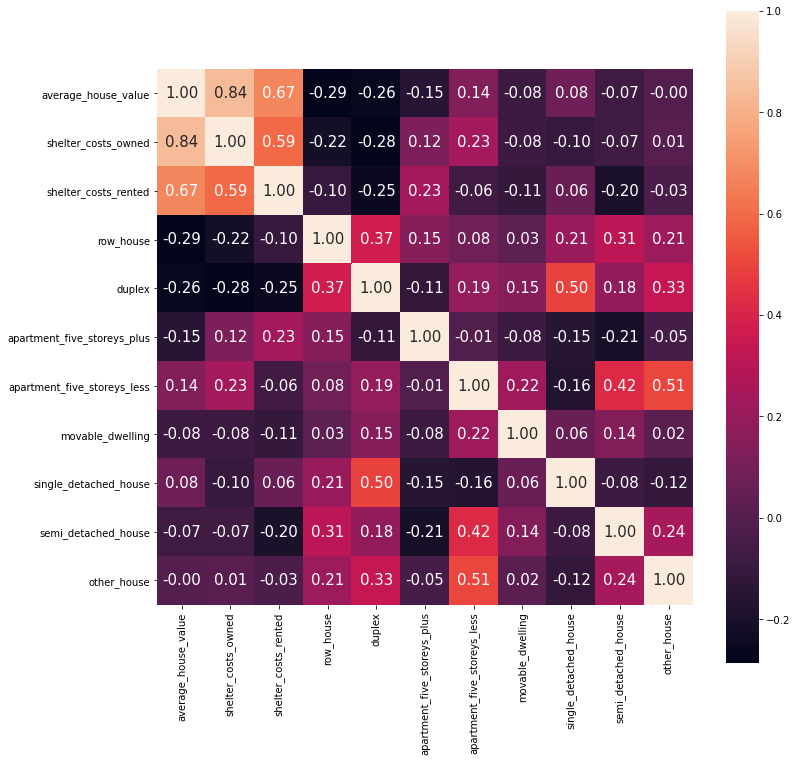

In [29]:
cols = coef_matrix.iloc[(-np.abs(coef_matrix["average_house_value"].values)).argsort()].index[:11]

coef = np.corrcoef(latest_df[cols].values.T)
fig, ax = plt.subplots(figsize=(12, 12))  # Sample figsize in inches
hm = sns.heatmap(
    coef,
    cbar=True,
    annot=True,
    square=True,
    fmt=".2f",
    annot_kws={"size": 15},
    yticklabels=cols,
    xticklabels=cols,
    ax=ax,
)

## Plot Scatter_matrix

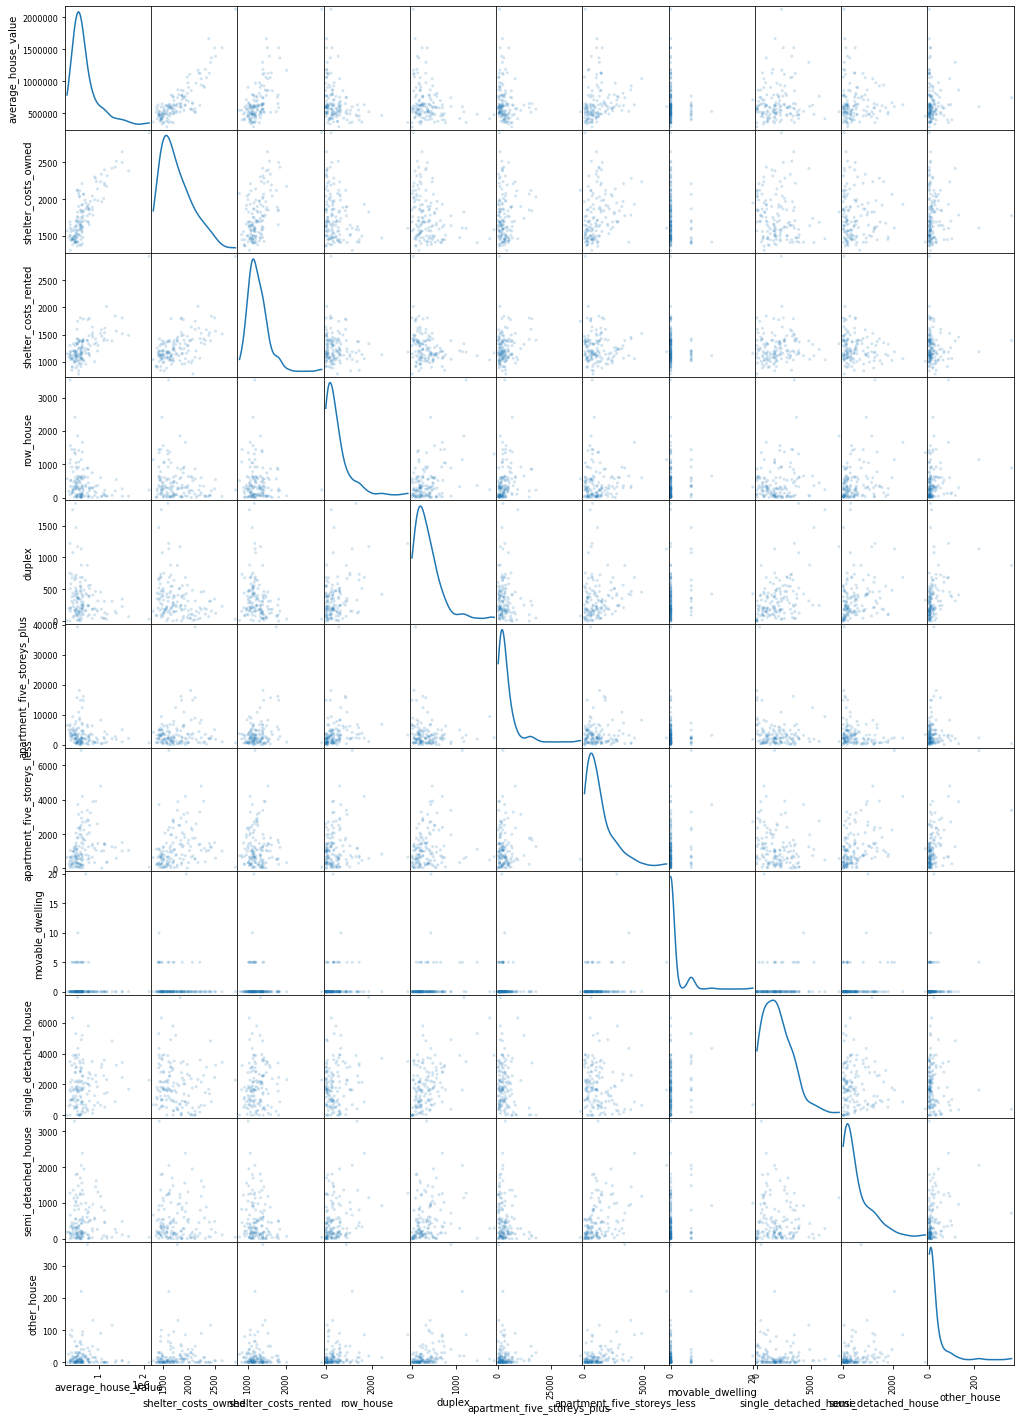

In [30]:
cols = coef_matrix.iloc[(-np.abs(coef_matrix["average_house_value"].values)).argsort()].index[:11]
scatter_matrix = scatter_matrix(
    latest_df[cols], alpha=0.2, figsize=(17, 25), diagonal="kde"
)

## Producing some Bar Graphs

In [31]:
temp = latest_df
temp["price_binned"] = pd.qcut(
    temp["average_house_value"], 5, labels=["very low", "low", "medium", "high", "very high"]
)
temp.price_binned.value_counts()

C:\Users\Office\.conda\envs\dev\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


very low     28
low          28
medium       28
high         28
very high    28
Name: price_binned, dtype: int64

In [32]:
list(cols)

['average_house_value',
 'shelter_costs_owned',
 'shelter_costs_rented',
 'row_house',
 'duplex',
 'apartment_five_storeys_plus',
 'apartment_five_storeys_less',
 'movable_dwelling',
 'single_detached_house',
 'semi_detached_house',
 'other_house']

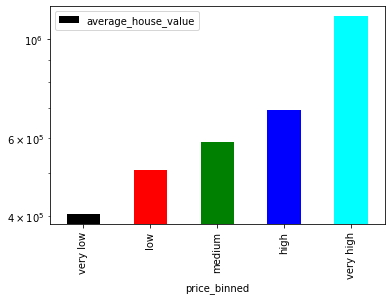

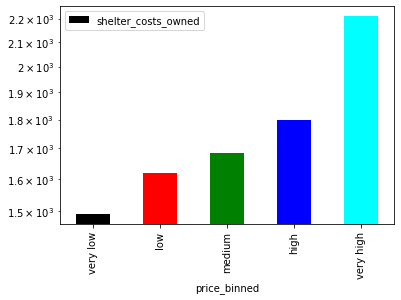

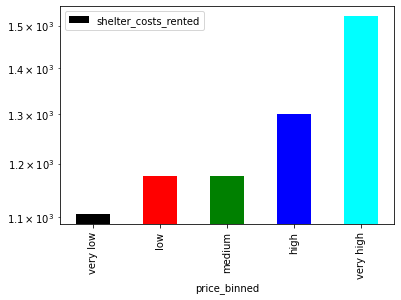

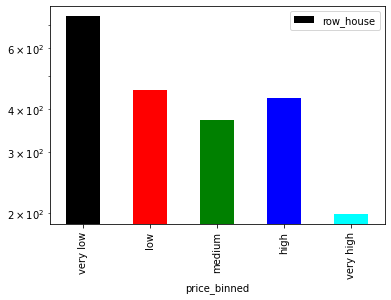

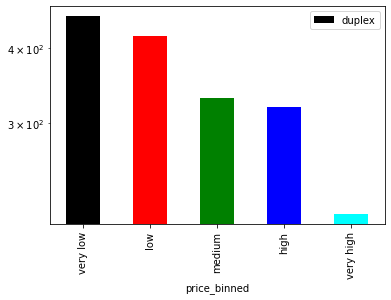

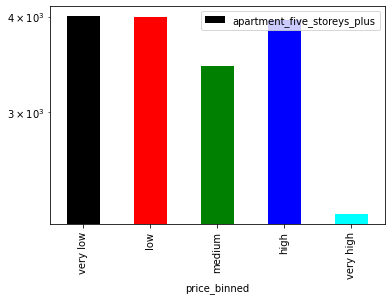

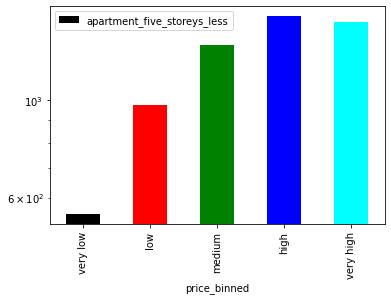

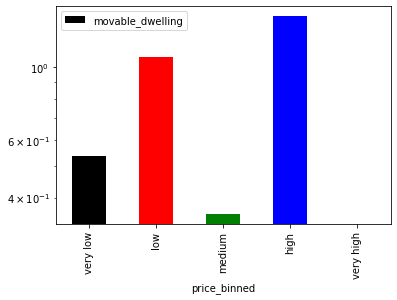

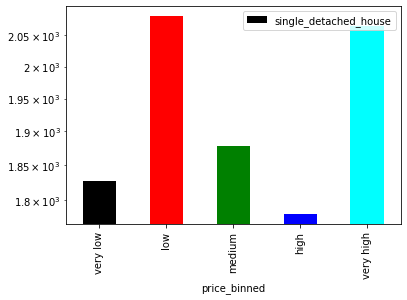

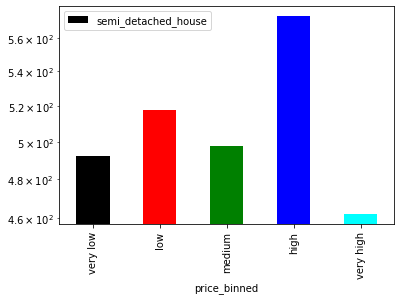

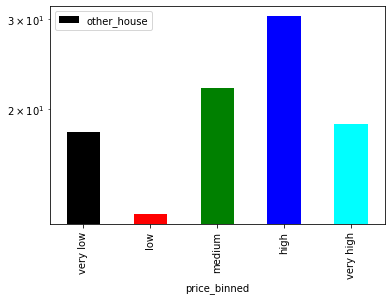

In [33]:
for feature in cols:
    temp.loc[:, ["price_binned", feature]].groupby(
        "price_binned"
    ).mean().reset_index().plot.bar(x="price_binned", y=feature, logy=True, color = ['black', 'red', 'green', 'blue', 'cyan'])

## Modeling

### Create Training/Testing Datasets and Performance Record Dataframe

In [34]:
# setting up variables
feature_1 = []
for x in useful_variables:
    if 'average_house_value' not in x:
        feature_1.append(x)
feature_1

['single_detached_house',
 'apartment_five_storeys_plus',
 'movable_dwelling',
 'semi_detached_house',
 'row_house',
 'duplex',
 'apartment_five_storeys_less',
 'shelter_costs_owned',
 'shelter_costs_rented']

In [35]:
# Create features and label
useful_features_1 = feature_1
X = latest_df.loc[:, useful_features_1]
y = latest_df.loc[:, "average_house_value"]

# Split data into Training and Testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=50
)

# Create a dataframe to store the performance of each models
scores = pd.DataFrame()

# Panel Visualizations

### Create Predict and Plot function for different Machine Learning Methods

In [54]:
# Create Predict and Plot function for ML methods
def try_different_method(method):
    method.fit(X_train, y_train)
    y_pred = method.predict(X_test)

    y_test_temp = y_test.reset_index(drop=True)
    order = y_pred.argsort(axis=0)
    y_pred = y_pred[order]
    y_test_temp = y_test_temp[order]

    #     maer = np.mean(abs(y_pred - y_test_temp) / y_test_temp)
    mse = metrics.mean_squared_error(y_test_temp, y_pred)
    r2 = metrics.r2_score(y_test_temp, y_pred)

    plt.figure(figsize=(10, 6))
    plt.plot(
        np.arange(len(y_pred)),
        y_test_temp,
        "ro",
        markersize=4,
        label="average_house_value",
        alpha=0.5,
    )
    plt.plot(
        np.arange(len(y_pred)),
        y_pred,
        "bo-",
        markersize=4,
        label="predict price",
        alpha=0.9,
    )
    
    plt.grid()
    plt.title("MSE: %f" % mse)
    print("mean_squared_error: %f" % mse)
    print("r2: %f" % r2)
    #     print('mean_abs_error_rate: %f' % maer)
    plt.legend()
    
    return (r2, mse)

### Random Forest algorithm

### Use GridSearch method for Random Forest to figure the best hyper-parameters

In [37]:
# parameters to search over with cross-validation
grid_params = [
    {
        "n_estimators": [10, 50, 100],
        "max_depth": [3, 6, 8, 10, None],
        "min_samples_leaf": [1, 2, 5],
    }
]

clf = GridSearchCV(RandomForestRegressor(), grid_params, cv=5, scoring="r2", n_jobs=2)
clf.fit(X_train, y_train)

print("Best parameter values: %r\n" % clf.best_params_)

Best parameter values: {'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 100}



### Use try_different_method function to plot prediction graph

mean_squared_error: 25830983999.657047
r2: 0.646690


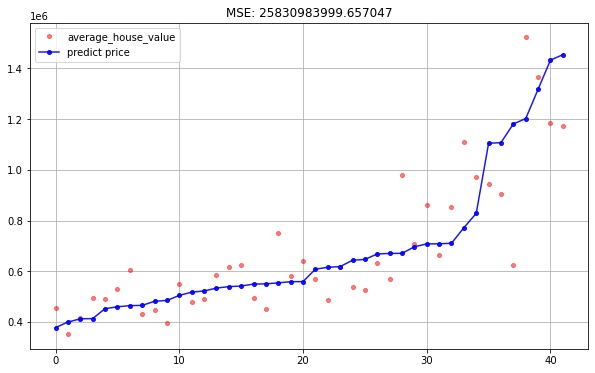

In [55]:
# RandomForestRegressor
rf = RandomForestRegressor(
    n_estimators=clf.best_params_["n_estimators"],
    criterion="mse",
    max_depth=clf.best_params_["max_depth"],
    min_samples_leaf=clf.best_params_["min_samples_leaf"],
    n_jobs=2,
    random_state=None,
)

performance_rf = try_different_method(rf)

scores.loc[0, "Random Forest"] = performance_rf[0]
scores.loc[1, "Random Forest"] = performance_rf[1]

### Plot Feature Importance graph

<AxesSubplot:title={'center':'variable Importance'}, xlabel='variables'>

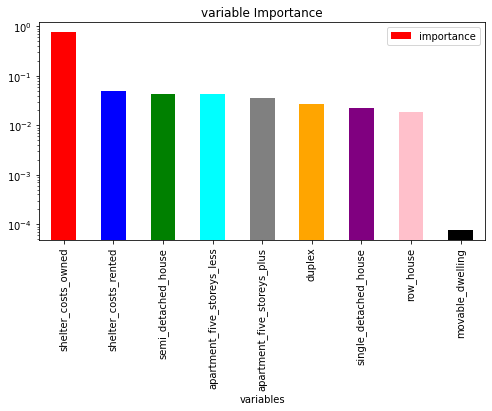

In [64]:
def importance_grpah():
    colors = ['red', 'blue', 'green', 'cyan', 'grey', 'orange', 'purple', 'pink', 'black']
    importance = pd.DataFrame({"variables": useful_features_1, "importance": rf.feature_importances_})
    importance.sort_values(by="importance", axis=0, ascending=False, inplace=True)
    importance_graph = importance[:18].plot.bar(
        x="variables",
        y="importance",   
        figsize=(8, 4),
        title="variable Importance",
        logy=True,
        color = colors
    )
    return importance_graph

importance_grpah()

## Decision Tree algorithm

In [40]:
# parameters to search over with cross-validation
grid_params = [{"max_depth": [3, 4, 5, 6, 8, None], "min_samples_leaf": [1, 2, 5, 7]}]

tree = GridSearchCV(DecisionTreeRegressor(), grid_params, cv=5, scoring="r2", n_jobs=2)
tree.fit(X_train, y_train)

print("Best parameter values: %r\n" % tree.best_params_)

Best parameter values: {'max_depth': 3, 'min_samples_leaf': 5}



mean_squared_error: 53958833150.022240
r2: 0.261964


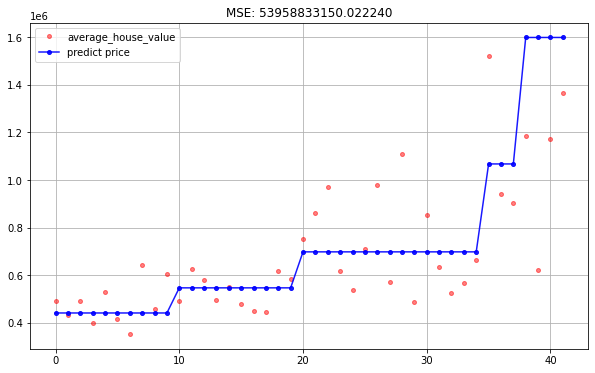

In [41]:
# RandomForestRegressor
tree = DecisionTreeRegressor(
    max_depth=tree.best_params_["max_depth"],
    min_samples_leaf=tree.best_params_["min_samples_leaf"],
    random_state=None,
)

performance_tree = try_different_method(tree)
scores.loc[0, "Decistion Tree"] = performance_tree[0]
scores.loc[1, "Decistion Tree"] = performance_tree[1]

## Conclusion

## Panel Visualization Functions

In [42]:
# Macro variables

def create_line_macro_pct():
    line_plot = df_macro_pct.hvplot.line(
        xlabel="Year",
        ylabel="Change Percentage",
        title='Macro Variables vs. Housing Prices'      
    )
    return line_plot

def create_cor_macro_pct():
    heatmap_macro_pct = sns.heatmap(
        df_macro_pct.corr(), 
        vmin=-1, 
        vmax=1, 
        annot=True,
    )
    return heatmap_macro_pct.figure


# Affordable neighborhood

# Most expensive neighborhoods

# Neighorhodd growth

# Housing price prediction

In [43]:
# Neighbourhood Map Function
def neighbourhood_map():
    """Neighbourhood Map"""  
    return px.scatter_mapbox(
        neighbourhood_locations,
        lat="lat",
        lon="lon",
        size="average_house_value",
        color="average_house_value",
        zoom=9,
        width=1000,
        height=600,
        title="Average House Values in Toronto",
        color_continuous_scale=px.colors.cyclical.IceFire
    )

neighbourhood_map_column = pn.Column("# Neighbourhood Map", neighbourhood_map())

In [44]:
# Neighbourhood Growth Map
def neighbourhood_growth_map():
    """Neighbourhood Growth Map"""  
    return px.scatter_mapbox(
        neighbourhood_growth_locations,
        lat="lat",
        lon="lon",
        size="Average Growth Rate",
        color="Average Growth Rate",
        zoom=9,
        width=1000,
        height=600,
        title="Growth Rates in Toronto",
        color_continuous_scale=px.colors.cyclical.IceFire
    )

neighbourhood_growth_map_column = pn.Column("# Neighbourhood Growth Map", neighbourhood_growth_map())

## Panel Dashboard

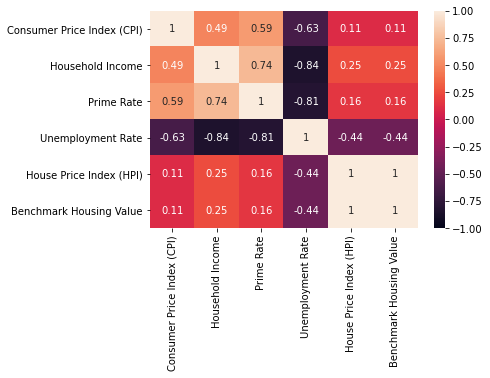

In [45]:
# Title for the Dashboard
dashboard_title ="##Predict Future Sales of GTA Residential Properties"

# Welcome text
welcome_plot = pn.Column(dashboard_title)

# Macro variables
macro_variables_analysis = pn.Column(create_line_macro_pct(), create_cor_macro_pct())

# Affordable neighborhood

# Most expensive neighborhoods

# Neighorhodd growth

# Housing price prediction



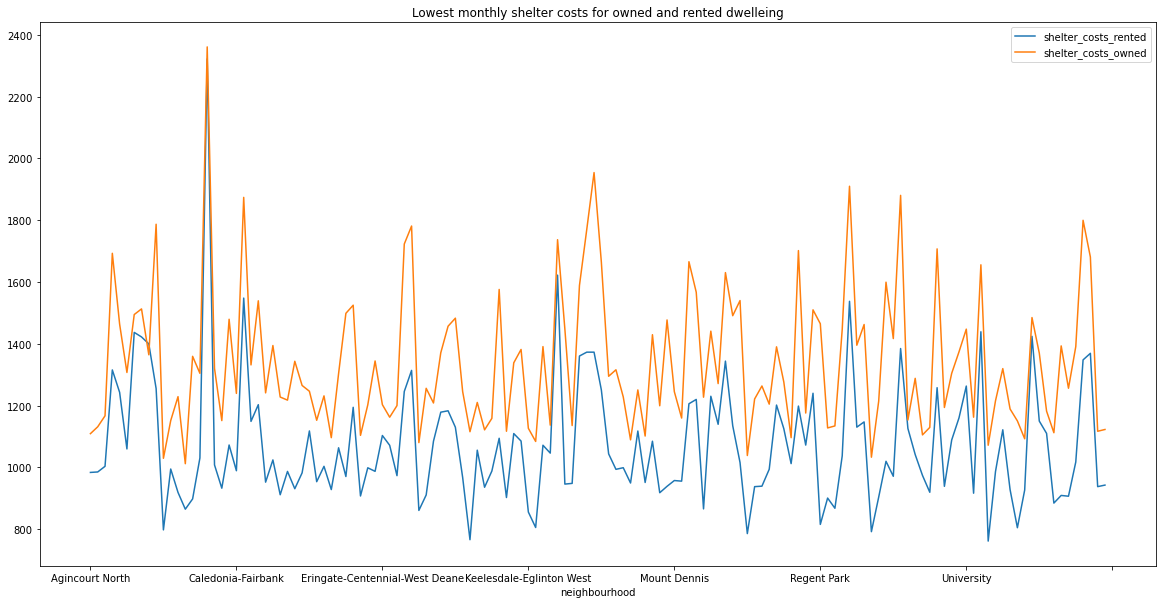

In [46]:
#plot of the monthly shelter costs for owned and rented dwelleing per Neighbourhood
avg_monthly_cost = GTA_data[['shelter_costs_rented', 'shelter_costs_owned']].groupby(["neighbourhood"]).mean()
avg_monthly_cost_plot = avg_monthly_cost.plot(figsize=(20, 10), title="Lowest monthly shelter costs for owned and rented dwelleing")

## Serve the Panel Dashboard

mean_squared_error: 22120446730.136272
r2: 0.697442
mean_squared_error: 53958833150.022240
r2: 0.261964


Tabs
    [0] Column
        [0] Markdown(str)
    [1] Column
        [0] HoloViews(NdOverlay)
        [1] Matplotlib(Figure)
    [2] HoloViews(Bars, name='GTA Expensive N...)
    [3] Column
        [0] Markdown(str)
        [1] Plotly(Figure)
    [4] HoloViews(Bars, name='Average Growth')
    [5] Column
        [0] Markdown(str)
        [1] Plotly(Figure)
    [6] Str(AxesSubplot, name='Average Monthly Cost')
    [7] HoloViews(Bars, name='Cheapest Neighborhoods')
    [8] Folium(Map, name='Cluster Map')
    [9] Row
        [0] Column
            [0] Str(tuple)
            [1] Str(tuple)
        [1] Str(AxesSubplot)
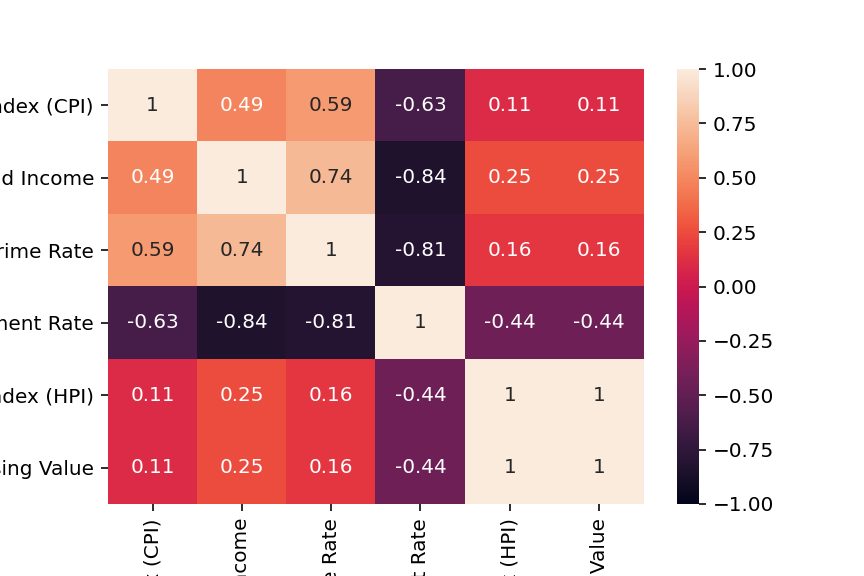

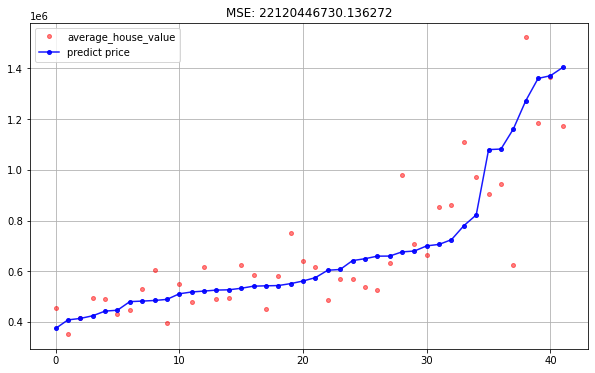

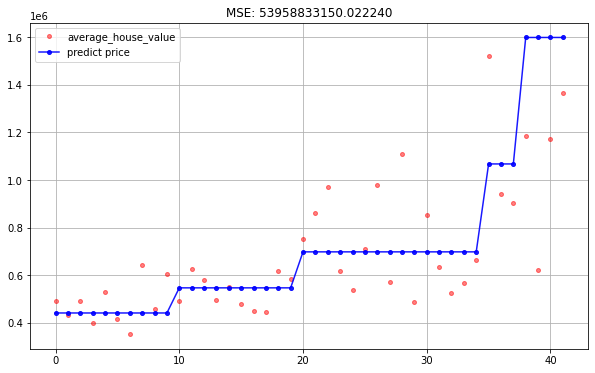

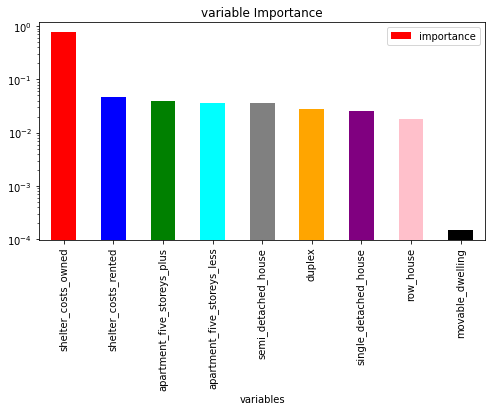

In [65]:
# Create the main dashboard
dashboard_tabs = pn.Tabs(             
                ("Welcome", welcome_plot),
                ("Macro variables Analysis", macro_variables_analysis),
                ("GTA Expensive Neighbourhoods", gta_expensive_neighbourhoods_plot),
                ("Expensive Neighbourhood Map", neighbourhood_map_column),
                ("Average Growth", average_growth_plot),
                ("Neighbourhood Growth Map", neighbourhood_growth_map_column),
                ("Average Monthly Cost", avg_monthly_cost_plot),
                ("Cheapest Neighborhoods", cheapest_plot),
                ('Cluster Map', map_clusters),
                ('Predictable Graph', pn.Row(pn.Column(try_different_method(rf),try_different_method(tree)),
                                            importance_grpah()))

)
dashboard_tabs.servable()